In [ ]:
!mkdir -p ~/.kaggle #membuat directory bernama kaggle 
!cp kaggle.json ~/.kaggle/ #copy file kaggle.json upload tadi ke directory baru
!chmod 600 ~/.kaggle/kaggle.json #berikan izin untuk file kaggle.jsonv

In [ ]:
!kaggle datasets download -d drgfreeman/rockpaperscissors

 97% 296M/306M [00:02<00:00, 140MB/s]
100% 306M/306M [00:02<00:00, 137MB/s]


In [ ]:
# Cek isi direktori kerja dan memastikan dataset telah berhasil didownload.
!ls

best_model2.h5	dataset      rockpaperscissors	    sample_data
best_model.h5	kaggle.json  rockpaperscissors.zip


In [ ]:
# Ekstrak file dataset dan hapus file zip dataset agar tidak memakan banyak tempat.
!unzip \*.zip &> /dev/null && rm *.zip

In [ ]:
# Cek isi direktori kerja untuk memastikan dataset telah berhasil diekstrak.
!ls

best_model2.h5	kaggle.json		  rock		     sample_data
best_model.h5	paper			  rockpaperscissors  scissors
dataset		README_rpc-cv-images.txt  rps-cv-images


In [ ]:
!mkdir dataset

mkdir: cannot create directory ‘dataset’: File exists


In [ ]:
!mv -t dataset paper rock scissors

mv: cannot move 'paper' to 'dataset/paper': Directory not empty
mv: cannot move 'rock' to 'dataset/rock': Directory not empty
mv: cannot move 'scissors' to 'dataset/scissors': Directory not empty


In [ ]:
!mkdir rockpaperscissors
!mv -t rockpaperscissors dataset
!rm -rf rps-cv-images
!rm *.txt

mkdir: cannot create directory ‘rockpaperscissors’: File exists
mv: cannot move 'dataset' to 'rockpaperscissors/dataset': Directory not empty


In [ ]:
!pip install split-folders

In [ ]:
!ls rockpaperscissors

dataset  test  train  val


In [ ]:
base_dir="/content/rockpaperscissors"
data_dir="/content/rockpaperscissors/dataset"

In [ ]:
import splitfolders
splitfolders.ratio(data_dir, output=base_dir, seed=1337, ratio=(.7,.15,.15),group_prefix=None)

Copying files: 2188 files [00:00, 3024.81 files/s]


In [ ]:
ls rockpaperscissors

dataset/  test/  train/  val/


In [ ]:
import os
train_path = os.path.join(base_dir,'train')
test_path  = os.path.join(base_dir,'test')
val_path   = os.path.join(base_dir,'val')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

Batch_size=32
augmen_gen = ImageDataGenerator(rescale=1. / 255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = augmen_gen.flow_from_directory(
    train_path,
    class_mode = 'categorical',
    shuffle=True,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb'
)

val_gen = augmen_gen.flow_from_directory(
    val_path,
    class_mode = 'categorical',
    shuffle=True,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb'
)

test_gen = augmen_gen.flow_from_directory(
    test_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (224,224),
    batch_size=Batch_size,
    color_mode ='rgb',
)

Found 1531 images belonging to 3 classes.
Found 326 images belonging to 3 classes.
Found 331 images belonging to 3 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import time

In [ ]:
ACCURACY_THRESHOLD = 0.95

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

In [ ]:
#model 1
model = Sequential()

model.add(InputLayer(input_shape=[224,224,3]))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 128)       0

In [ ]:
best_model_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(best_model_path,
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     verbose=1)
reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.000003, verbose=1)
Early_Stopping = myCallback()
callbacks_list = [checkpoint_callback, reduce_callback,Early_Stopping]

In [ ]:
learning_rate=0.001
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=learning_rate),
             metrics='accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
import time
start = time.time()
H = model.fit(train_gen, epochs=100,validation_data=val_gen, validation_steps = 4, verbose=1, callbacks=[callbacks_list])

End = time.time()
print ("training time: ", End-start,"s")

Epoch 1/100
48/48 [==============================] - 28s 524ms/step - loss: 1.8479 - accuracy: 0.4311 - val_loss: 1.1034 - val_accuracy: 0.3984

Epoch 00001: val_accuracy improved from -inf to 0.39844, saving model to best_model.h5
Epoch 2/100
48/48 [==============================] - 24s 507ms/step - loss: 0.8984 - accuracy: 0.6140 - val_loss: 1.0636 - val_accuracy: 0.4141

Epoch 00002: val_accuracy improved from 0.39844 to 0.41406, saving model to best_model.h5
Epoch 3/100
48/48 [==============================] - 24s 507ms/step - loss: 0.7308 - accuracy: 0.6937 - val_loss: 1.0432 - val_accuracy: 0.4141

Epoch 00003: val_accuracy did not improve from 0.41406
Epoch 4/100
48/48 [==============================] - 24s 507ms/step - loss: 0.5460 - accuracy: 0.7877 - val_loss: 0.9074 - val_accuracy: 0.4062

Epoch 00004: val_accuracy did not improve from 0.41406
Epoch 5/100
48/48 [==============================] - 24s 510ms/step - loss: 0.4062 - accuracy: 0.8589 - val_loss: 0.7910 - val_accura

In [ ]:
#model 2
model2 = Sequential()

model2.add(InputLayer(input_shape=[224,224,3]))
model2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(pool_size=2))
model2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(pool_size=2))
model2.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(pool_size=2))
model2.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(pool_size=2))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Flatten())

model2.add(Dense(512, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(3, activation='softmax'))

In [ ]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 128)      

In [ ]:
best_model2_path = 'best_model2.h5'
checkpoint_callback2 = ModelCheckpoint(best_model2_path,
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     verbose=1)
reduce_callback2 = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.000003, verbose=1)
Early_Stopping = myCallback()
callbacks2_list = [checkpoint_callback2, reduce_callback2,Early_Stopping]

In [ ]:
learning_rate=0.00001
model2.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=learning_rate),
             metrics='accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start = time.time()
H2 = model2.fit(train_gen, epochs=100,validation_data=val_gen, validation_steps = 4, verbose=1, callbacks=[callbacks2_list])

End = time.time()
print ("training time: ", End-start,"s")

Epoch 1/100
48/48 [==============================] - 28s 543ms/step - loss: 1.1110 - accuracy: 0.3815 - val_loss: 1.0927 - val_accuracy: 0.3750

Epoch 00001: val_accuracy improved from -inf to 0.37500, saving model to best_model2.h5
Epoch 2/100
48/48 [==============================] - 25s 518ms/step - loss: 1.0714 - accuracy: 0.4324 - val_loss: 1.0897 - val_accuracy: 0.3906

Epoch 00002: val_accuracy improved from 0.37500 to 0.39062, saving model to best_model2.h5
Epoch 3/100
48/48 [==============================] - 25s 514ms/step - loss: 1.0275 - accuracy: 0.4644 - val_loss: 1.0793 - val_accuracy: 0.5938

Epoch 00003: val_accuracy improved from 0.39062 to 0.59375, saving model to best_model2.h5
Epoch 4/100
48/48 [==============================] - 25s 512ms/step - loss: 0.9951 - accuracy: 0.5101 - val_loss: 1.0727 - val_accuracy: 0.5781

Epoch 00004: val_accuracy did not improve from 0.59375
Epoch 5/100
48/48 [==============================] - 25s 511ms/step - loss: 0.9357 - accuracy: 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
model.load_weights(best_model_path)

ypred = model.predict(test_gen)
predictions = np.argmax(ypred, axis = 1)

print(classification_report(test_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       108
           1       0.93      0.99      0.96       110
           2       0.96      0.96      0.96       113

    accuracy                           0.95       331
   macro avg       0.96      0.95      0.95       331
weighted avg       0.96      0.95      0.95       331



Confusion matrix, without normalization
[[ 98   5   5]
 [  1 109   0]
 [  1   3 109]]


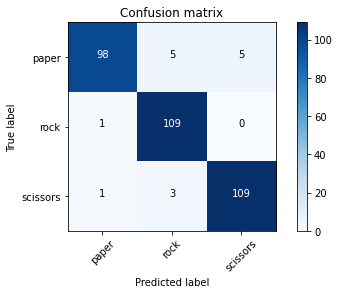

In [ ]:
cnf_matrix=confusion_matrix(test_gen.classes,predictions)
plot_confusion_matrix(cnf_matrix, classes=test_gen.class_indices)

In [ ]:
model2.load_weights(best_model2_path)

ypred2 = model2.predict(test_gen)
predictions2 = np.argmax(ypred2, axis = 1)

print(classification_report(test_gen.classes,predictions2))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       108
           1       0.86      0.94      0.90       110
           2       0.95      0.95      0.95       113

    accuracy                           0.92       331
   macro avg       0.92      0.92      0.92       331
weighted avg       0.92      0.92      0.92       331



Confusion matrix, without normalization
[[ 94  11   3]
 [  4 103   3]
 [  0   6 107]]


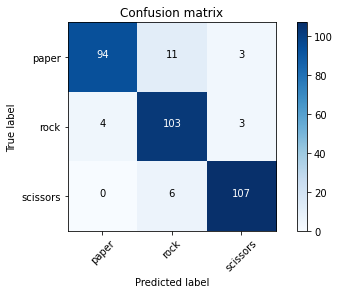

In [ ]:
cnf_matrix2=confusion_matrix(test_gen.classes,predictions2)
plot_confusion_matrix(cnf_matrix2, classes=test_gen.class_indices)

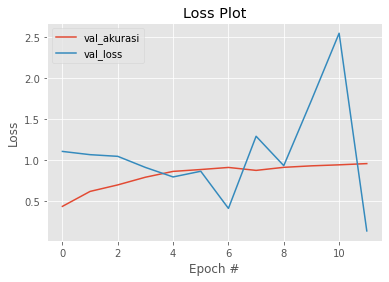

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 12), H.history["accuracy"], label="val_akurasi")
plt.plot(np.arange(0, 12), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

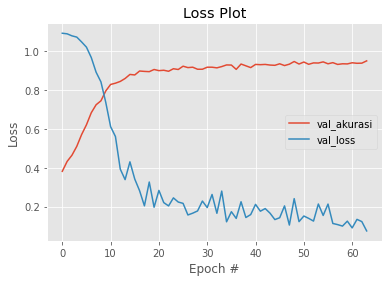

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 64), H2.history["accuracy"], label="val_akurasi")
plt.plot(np.arange(0, 64), H2.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from keras.preprocessing import image

X_test = []
labels = []

labels_dict = {
    "paper" : 0,
    "rock" : 1,
    "scissors" : 2
}

filepath = test_path

for file in os.listdir(filepath):
    
    if file in labels_dict.keys():
        
        for img_path in os.listdir(os.path.join(filepath, file)):
            
            img = image.load_img(os.path.join(filepath, file, img_path), target_size=(224,224))
            img = image.img_to_array(img)/255.0
            
            X_test.append(img)
            labels.append(labels_dict[file])

X_test = np.array(X_test)

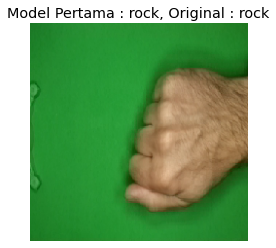

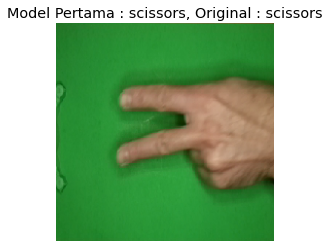

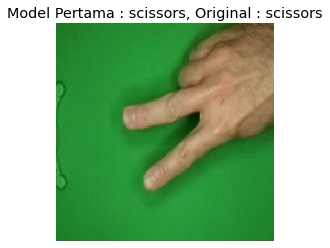

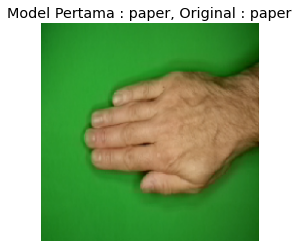

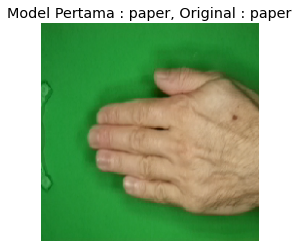

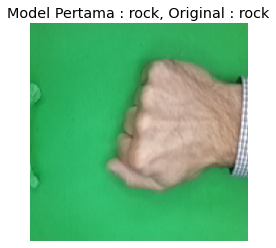

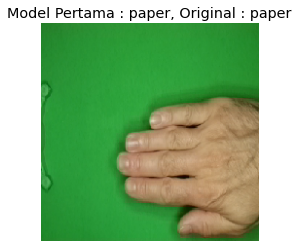

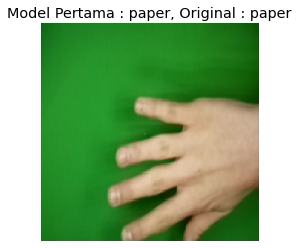

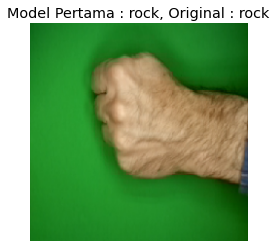

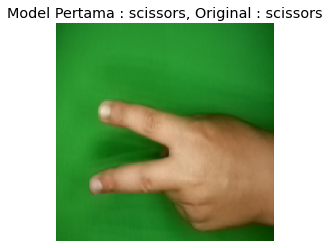

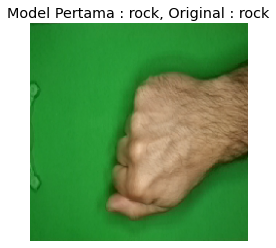

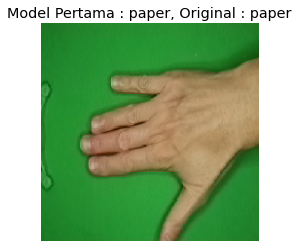

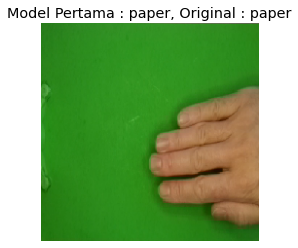

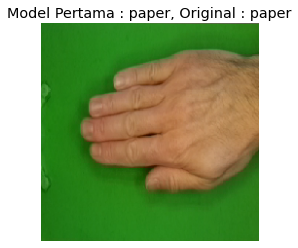

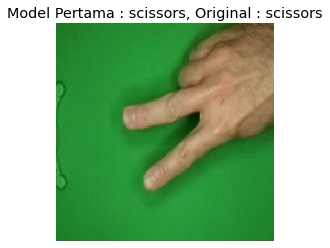

training time:  0.1551206111907959 s


In [ ]:
rev_label_dict = dict([(value, key) for (key, value) in labels_dict.items()])

import random

for i in range(15):
    start = time.time()
    idx = random.randint(0, len(X_test))
    plt.imshow(X_test[idx])
    plt.axis("off")
    pred = rev_label_dict.get(np.argmax(mo  del.predict(X_test[idx].reshape(1,224,224,3))))
    org = rev_label_dict.get(labels[idx])
    plt.title("Model Pertama : {}, Original : {}".format(pred, org))
    plt.show()
    End = time.time()

print ("training time: ", End-start,"s")

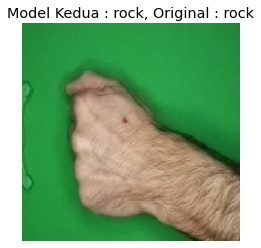

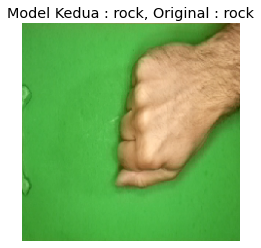

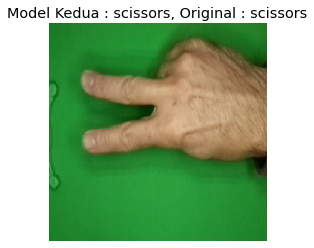

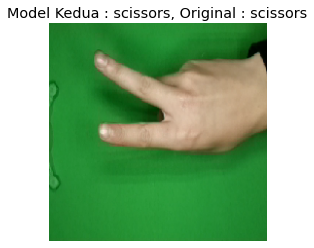

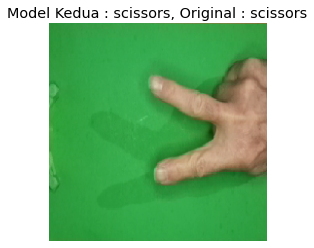

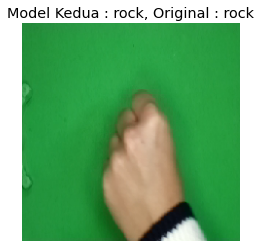

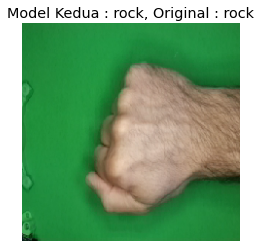

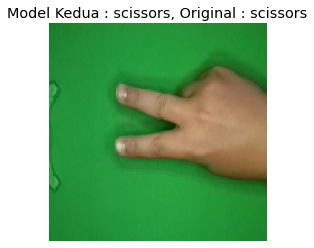

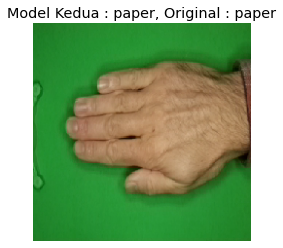

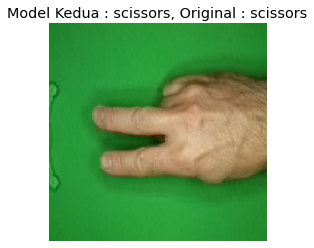

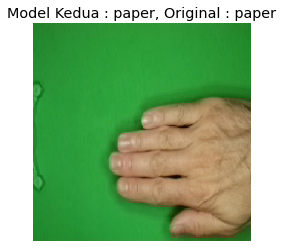

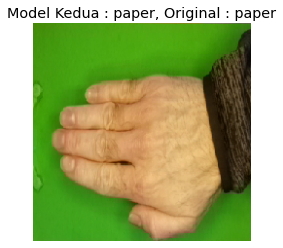

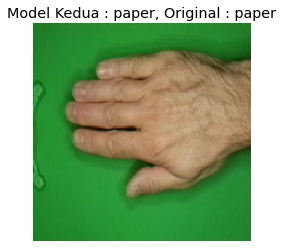

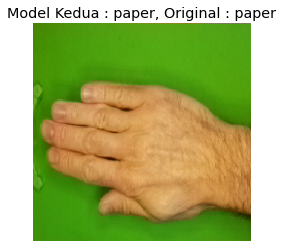

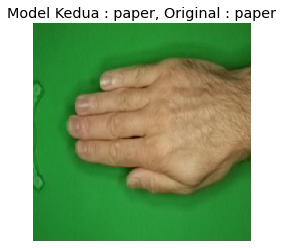

training time:  0.1924445629119873 s


In [ ]:
rev_label_dict = dict([(value, key) for (key, value) in labels_dict.items()])

import random

for i in range(15):
    start = time.time()
    idx = random.randint(0, len(X_test))
    plt.imshow(X_test[idx])
    plt.axis("off")
    pred2 = rev_label_dict.get(np.argmax(model2.predict(X_test[idx].reshape(1,224,224,3))))
    org = rev_label_dict.get(labels[idx])
    plt.title("Model Kedua : {}, Original : {}".format(pred2, org))
    plt.show()
    End = time.time()

print ("training time: ", End-start,"s")

Saving download.jfif to download.jfif
download.jfif
scissors


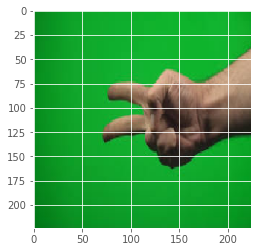

In [ ]:
from google.colab import files

uploads = files.upload()

for fn in uploads.keys():
    path = fn
    img_src = image.load_img(path, target_size=(224, 224))
    imgplot = plt.imshow(img_src)
    x = image.img_to_array(img_src)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=20)

    print(fn)
    if classes[0, 0] == 1:
        print('rock')
    elif classes[0, 1] == 1:
        print('paper')
    elif classes[0, 2] == 1:
        print('scissors')

Saving images.jfif to images (2).jfif
images.jfif
rock


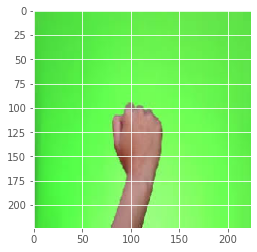

In [ ]:
from google.colab import files

uploads = files.upload()

for fn in uploads.keys():
    path = fn
    img_src = image.load_img(path, target_size=(224, 224))
    imgplot = plt.imshow(img_src)
    x = image.img_to_array(img_src)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model2.predict(images, batch_size=20)

    print(fn)
    if classes[0, 0] == 1:
        print('rock')
    elif classes[0, 1] == 1:
        print('paper')
    elif classes[0, 2] == 1:
        print('scissors')